In [1]:
import sys
from matplotlib import pyplot as plt
sys.path.append("../")
import dghf
from scripts import canvass_download
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.ticker import LogLocator
"""
Create an animated gif
"""

'\nCreate an animated gif\n'

In [2]:
df = canvass_download.read_canvass_data(out_dir="../out/test/cache_canvass")
cids = canvass_download.exemplar_cid_assays()[:3]
data_demo = canvass_download.demo_x_y_data(df=df,cid_assay=cids)

100%|████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.76it/s]


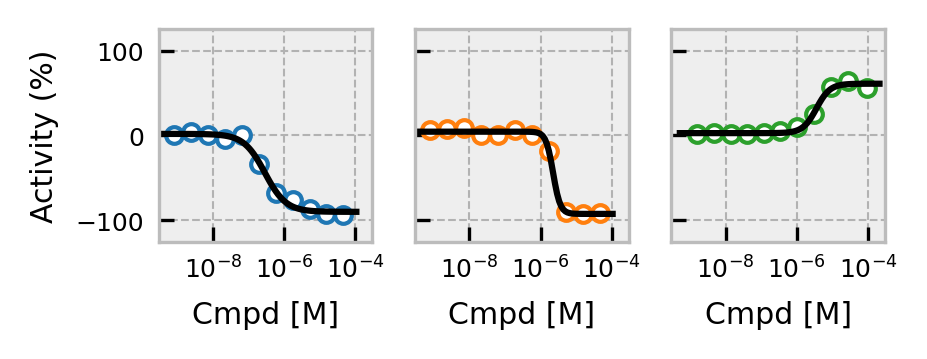

In [3]:
# modeled after https://matplotlib.org/2.1.2/gallery/animation/subplots.html
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig = plt.figure()
        fit_kw = [dghf.fit(x, y) for x, y in data_demo]
        colors = dghf._plotting_colors()
        plt.rcParams.update({'font.size': 6})
        plt.close("all")
        plt.style.use("bmh")
        fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(3,1.2),
                                sharex=True,sharey=True,dpi=300)
        dghf._format_axes(axs,ylabel="Activity (%)",wspace=0.2)
        self.lines = []
        self.line_data = []
        self.N = 50
        self.log_N = 100
        for i,(ax,(x,y),kw) in enumerate(zip(axs,data_demo,fit_kw)):
            _ , plot_lines = dghf._single_plot(ax=ax,x=x,y=y,kw=kw,color=colors[i % len(colors)],
                                               log_points=self.log_N,linestyle="-",
                                               factor_extra=3)
            plot_lines = plot_lines[0]
            self.line_data.append([plot_lines.get_xdata(),plot_lines.get_ydata()])
            self.lines.append(plot_lines)
        for a in axs:
            a.set_ylim([-125,125])
            a.set_xlim([3e-10,3e-4])
            a.xaxis.set_major_locator(LogLocator(base=10, numticks=3))
        animation.TimedAnimation.__init__(self, fig, interval=30, blit=True)

    def new_frame_seq(self):
        return iter(range(self.N))

    
    def _draw_frame(self, framedata):
        N_to_plot = int(np.ceil(framedata * self.log_N/self.N))
        for l,(x,y) in zip(self.lines,self.line_data):
            l.set_data(x[:N_to_plot],y[:N_to_plot])
        self._drawn_artists = self.lines

    def _init_draw(self):
        for l in self.lines:
            l.set_data([], [])

ani = SubplotAnimation()
ani.save('gallery.gif',writer=PillowWriter(fps=30))